In [1]:
import cpuinfo
cpuinfo.get_cpu_info()['brand']

'Intel(R) Core(TM) i3-6100U CPU @ 2.30GHz'

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2554620132489827205, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13480793315028542732
 physical_device_desc: "device: XLA_CPU device"]

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [4]:
tf.test.gpu_device_name()

''

In [5]:
import imageio
from tqdm import tqdm
import multiprocessing as mp
import pandas as pd
import seaborn as sns

In [6]:
%run ../utils/unet.py
%run ../utils/helpers.py
%run ../utils/generate_flat_bg.py
%run ../utils/generate_bg.py
%run ../utils/generate_train_set.py

Using TensorFlow backend.


In [7]:
h_size = 256
w_size = 256
start_neurons = 16
mask_pool_size = 10
train_num = 50
bg_admix_iters = 5

cores_count = mp.cpu_count()
cpu_pool = mp.Pool(processes=cores_count)

In [8]:
train_x = np.zeros((train_num, h_size, w_size, 3), dtype='float32')
train_y = np.zeros((train_num, h_size, w_size, 1), dtype='float32')

model = get_compiled_model(h_size, w_size, start_neurons)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
sample_img = imageio.imread('../data/train/original_sample_blur_1000.jpg', pilmode="RGB")
mask_img = imageio.imread('../data/train/original_sample_mask_inv_1000.jpg', pilmode="RGB", as_gray=True)

original_smpl = np.array(sample_img, dtype=np.uint8)
original_mask = np.array(mask_img, dtype=np.uint8)

In [10]:
simplest_flat_bg = imageio.imread('../data/train/simplest_flat_bg.jpg', pilmode="RGB")
simple_bg = imageio.imread('../data/train/simplest_bg.jpg', pilmode="RGB")

In [11]:
mask_pool = [
    get_mask(h_size, w_size) 
    for _ in tqdm(range(mask_pool_size))
]

100%|██████████| 10/10 [00:00<00:00, 11.33it/s]


In [12]:
# %%time
# for k in range(train_num): # tqdm
#     img, msk = next_pair(
#         original_mask,
#         original_smpl,
#         simplest_flat_bg,
#         simple_bg,
#         mask_pool,
#     )
#     train_x[k] = img
#     train_y[k] = msk

In [13]:
%%time
coros = [
    cpu_pool.apply_async(
        next_pair, 
        args=(
            original_mask,
            original_smpl,
            simplest_flat_bg,
            simple_bg,
            mask_pool,
        )
    ) 
    for _ in range(train_num)
]
k = 0
for img, msk in [p.get() for p in coros]:
    train_x[k] = img
    train_y[k] = msk
    k += 1

CPU times: user 446 ms, sys: 812 ms, total: 1.26 s
Wall time: 7.81 s


In [14]:
acc = []
val_acc = []
for _ in range (1):
    history = model.fit(train_x, train_y,
                        batch_size=32,
                        epochs=1,
                        verbose=1,
                        validation_split=0.1
                       )    
    acc_ = history.history['my_iou_metric'][0]
    val_acc_ = history.history['val_my_iou_metric'][0]
    acc.append(acc_)
    val_acc.append(val_acc_)
    if acc_ > 0.99:
        break

Instructions for updating:
Use tf.cast instead.
Train on 45 samples, validate on 5 samples
Epoch 1/1
45/45 [==============================] - 106s 2s/step - loss: 1.3639 - my_iou_metric: 0.0000e+00 - val_loss: 1.3013 - val_my_iou_metric: 0.0000e+00


/usr/local/lib/python3.5/dist-packages/numpy/lib/polynomial.py:627: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


ValueError: On entry to DLASCL parameter number 4 had an illegal value

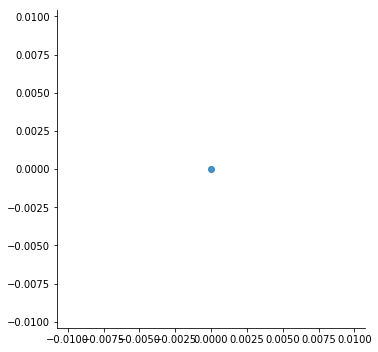

In [15]:
df = pd.DataFrame({'x': list(range(len(acc))), 'y': acc})
sns.lmplot(x="x", y="y", data=df, order=2);

In [ ]:
df = pd.DataFrame({'x': list(range(len(val_acc))), 'y': val_acc})
sns.lmplot(x="x", y="y", data=df, order=2);